In [106]:
import numpy as np
import pandas as pd
import seaborn as sb
from dython.nominal import associations, identify_nominal_columns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [107]:
col_names = ["symboling", "normalized-losses", "make",
             "fuel-type", "aspiration", "num-of-doors", "body-style", "drive-wheels",
             "engine-location", "wheel-base", "length", "width", "height", "curb-weight",
             "engine-type", "num-of-cylinders", "engine-size", "fuel-system", "bore",
             "stroke", "compression-ratio", "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"]

df = pd.read_csv("data.csv", header=None, names=col_names)


# Perform exploratory data analysis and feature selection

## Modifying data from "?" to NaN

In [108]:
df.isnull().sum()


symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [109]:
df.replace("?", float("NaN"), inplace=True)

In [110]:
df.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

## Converting types of certain columns from "object" to "numeric"

In [111]:
df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [112]:
df["price"] =  pd.to_numeric(df["price"])
df["bore"] = pd.to_numeric(df["bore"])
df["stroke"] = pd.to_numeric(df["stroke"])
df["horsepower"] = pd.to_numeric(df["horsepower"])
df["peak-rpm"] = pd.to_numeric(df["peak-rpm"])
df["normalized-losses"] = pd.to_numeric(df["normalized-losses"])

In [113]:
df.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

## Replacing "normalized-losses" missing values with the mean of the column

In [114]:
df["normalized-losses"] = df["normalized-losses"].replace(np.nan, df.describe()["normalized-losses"]["mean"])


In [115]:
df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,122.0,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,122.0,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0


## Dropping rows with missing values

In [116]:
print(df.shape)
df.isnull().sum()

(205, 26)


symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         2
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 4
stroke               4
compression-ratio    0
horsepower           2
peak-rpm             2
city-mpg             0
highway-mpg          0
price                4
dtype: int64

In [117]:
for i in df.columns:
    if (df[i].isnull().sum() != 0):
        df = df.drop(list((df.loc[df[i].isnull()]).index))

In [118]:
print(df.shape)
df.isnull().sum()


(193, 26)


symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

## Generating Correlation Matrix

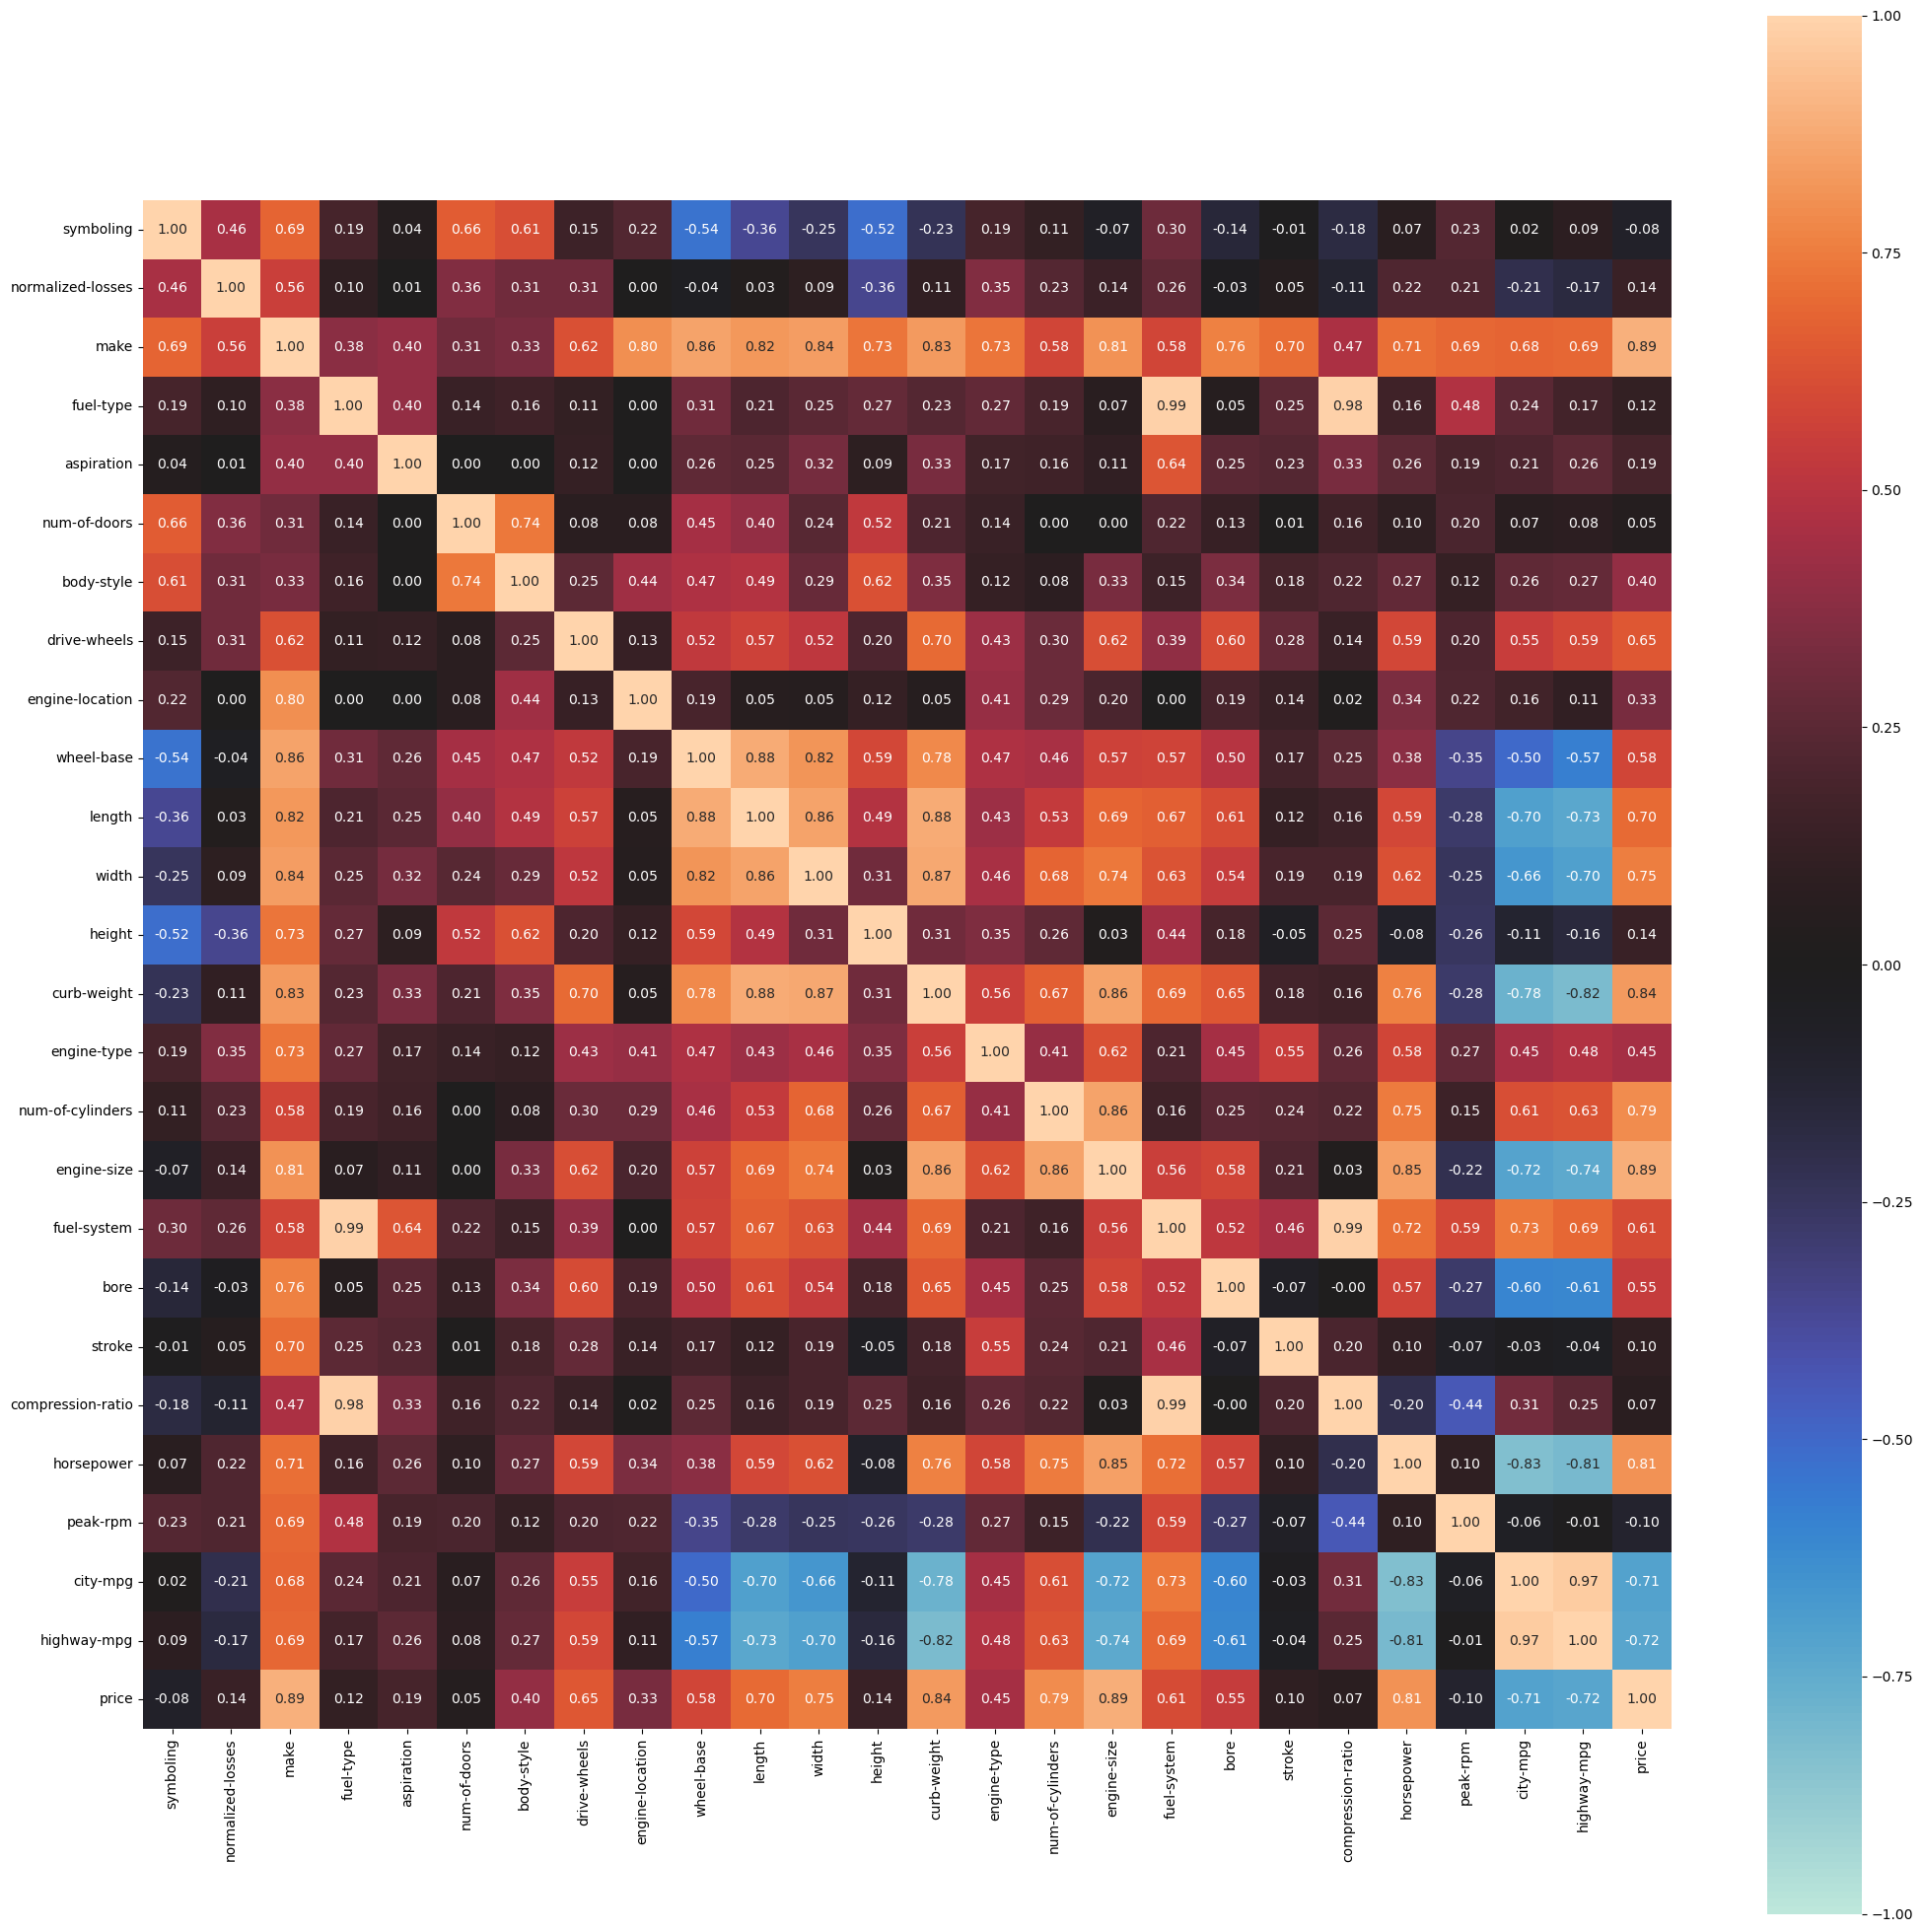

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
symboling,1.000000,0.455135,0.686565,0.185730,0.042855,0.659122,0.613002,0.154695,0.224529,-0.536516,...,-0.068327,0.300761,-0.144785,-0.010884,-0.175160,0.069491,0.227899,0.017639,0.085775,-0.084835
normalized-losses,0.455135,1.000000,0.559295,0.097808,0.007493,0.355703,0.305731,0.307063,0.002785,-0.043395,...,0.142821,0.262221,-0.025608,0.054589,-0.112980,0.217727,0.213594,-0.208081,-0.166290,0.138700
make,0.686565,0.559295,1.000000,0.380131,0.403516,0.307566,0.328432,0.619567,0.803272,0.859091,...,0.812269,0.584371,0.760610,0.704270,0.467479,0.714414,0.691590,0.682665,0.687811,0.893447
fuel-type,0.185730,0.097808,0.380131,1.000000,0.403328,0.140555,0.156804,0.112777,0.000000,0.310196,...,0.066091,0.986824,0.052378,0.253837,0.984951,0.156712,0.477885,0.242396,0.174032,0.115440
aspiration,0.042855,0.007493,0.403516,0.403328,1.000000,0.000000,0.000000,0.117189,0.000000,0.263988,...,0.109131,0.640238,0.247400,0.232950,0.332095,0.255771,0.193908,0.205628,0.256251,0.186073
num-of-doors,0.659122,0.355703,0.307566,0.140555,0.000000,1.000000,0.741987,0.076493,0.076909,0.447460,...,0.003019,0.217891,0.127156,0.008421,0.161471,0.097046,0.200355,0.068485,0.082160,0.046460
body-style,0.613002,0.305731,0.328432,0.156804,0.000000,0.741987,1.000000,0.252325,0.436003,0.474076,...,0.330477,0.153685,0.336717,0.179713,0.215311,0.271186,0.120482,0.262937,0.273691,0.401739
drive-wheels,0.154695,0.307063,0.619567,0.112777,0.117189,0.076493,0.252325,1.000000,0.129623,0.523548,...,0.616785,0.394052,0.603936,0.279188,0.137582,0.592506,0.203955,0.552117,0.587562,0.648366
engine-location,0.224529,0.002785,0.803272,0.000000,0.000000,0.076909,0.436003,0.129623,1.000000,0.192972,...,0.199546,0.000000,0.189345,0.139339,0.020386,0.343559,0.215106,0.164217,0.106960,0.330848
wheel-base,-0.536516,-0.043395,0.859091,0.310196,0.263988,0.447460,0.474076,0.523548,0.192972,1.000000,...,0.568375,0.571398,0.495957,0.174225,0.252234,0.377040,-0.350823,-0.504499,-0.571771,0.584951


In [119]:
categorical_features = identify_nominal_columns(df)

complete_correlation = associations(
    df, filename='correlation_matrix.png', figsize=(25, 25))

df_complete_corr = complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(
    axis=0, how='all')


## Resetting dataset and removing unwanted features based on relation of every other feature with "price"

In [120]:
df.shape

(193, 26)

In [121]:
df = pd.read_csv("data.csv", header=None, names=col_names)

df = df.drop(columns=["compression-ratio", "stroke", "peak-rpm", "num-of-doors", "normalized-losses", "symboling"])

df.replace("?", float("NaN"), inplace=True)
df["price"] = pd.to_numeric(df["price"])
df["bore"] = pd.to_numeric(df["bore"])
df["horsepower"] = pd.to_numeric(df["horsepower"])

for i in df.columns:
    if (df[i].isnull().sum() != 0):
        df = df.drop(list((df.loc[df[i].isnull()]).index))
df.reset_index(drop=True, inplace=True)


In [122]:
df.shape

(195, 20)

## Encoding the catagorical features using

In [123]:
cat_cols=['aspiration', 'body-style', 'drive-wheels', 'fuel-type',
       'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system', 'make']

In [124]:
for cat_col in cat_cols:
  dummy = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=True)
  df = pd.concat([df, dummy], axis=1)
  df = df.drop(cat_col, axis=1)

# Visualization

## Splitting data into train and test

In [125]:
df_train, df_test = train_test_split(df, 
                      test_size=0.3)
print("X_train shape:", df_train.drop("price",axis=1).shape, "| X_test shape:", df_test.drop("price",axis=1).shape)
print("y_train mean:", round(np.mean(df_train["price"]),2), "| y_test mean:", round(np.mean(df_test["price"]),2))
print(df_train.shape[1], "features:", df_train.drop("price",axis=1).columns.to_list())

X_train shape: (136, 54) | X_test shape: (59, 54)
y_train mean: 13097.95 | y_test mean: 13593.93
55 features: ['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'horsepower', 'city-mpg', 'highway-mpg', 'aspiration_turbo', 'body-style_hardtop', 'body-style_hatchback', 'body-style_sedan', 'body-style_wagon', 'drive-wheels_fwd', 'drive-wheels_rwd', 'fuel-type_gas', 'engine-location_rear', 'engine-type_l', 'engine-type_ohc', 'engine-type_ohcf', 'engine-type_ohcv', 'num-of-cylinders_five', 'num-of-cylinders_four', 'num-of-cylinders_six', 'num-of-cylinders_three', 'num-of-cylinders_twelve', 'fuel-system_2bbl', 'fuel-system_idi', 'fuel-system_mfi', 'fuel-system_mpfi', 'fuel-system_spdi', 'fuel-system_spfi', 'make_audi', 'make_bmw', 'make_chevrolet', 'make_dodge', 'make_honda', 'make_isuzu', 'make_jaguar', 'make_mazda', 'make_mercedes-benz', 'make_mercury', 'make_mitsubishi', 'make_nissan', 'make_peugot', 'make_plymouth', 'make_porsche', 'make_saab', 'make_subaru

## Relation between Horsepower and Price

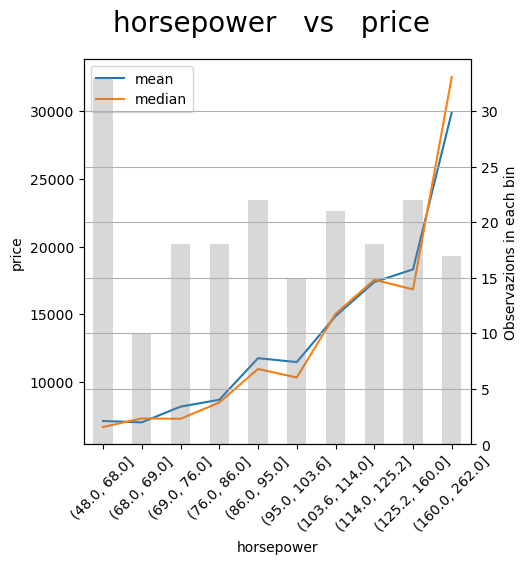

In [126]:
x, y = "horsepower", "price"
figsize = (5, 5)
# bin plot
dtf_noNan = df[df[x].notnull()]
breaks = np.quantile(dtf_noNan[x], q=np.linspace(0, 1, 11))
groups = dtf_noNan.groupby([pd.cut(dtf_noNan[x], bins=breaks,
                                   duplicates='drop')])[y].agg(['mean', 'median', 'size'])
fig, ax = plt.subplots(figsize=figsize)
fig.suptitle(x+"   vs   "+y, fontsize=20)
groups[["mean", "median"]].plot(kind="line", ax=ax)
groups["size"].plot(kind="bar", ax=ax, rot=45, secondary_y=True,
                    color="grey", alpha=0.3, grid=True)
ax.set(ylabel=y)
ax.right_ax.set_ylabel("Observazions in each bin")
plt.show()


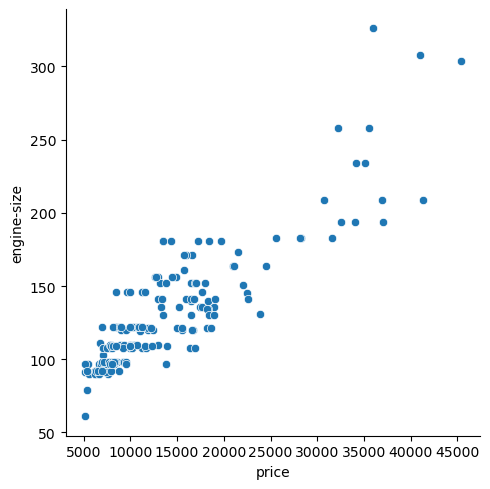

In [127]:
sb.relplot(
    data=df,
    x="price", y="engine-size"
)


## Feature Importance

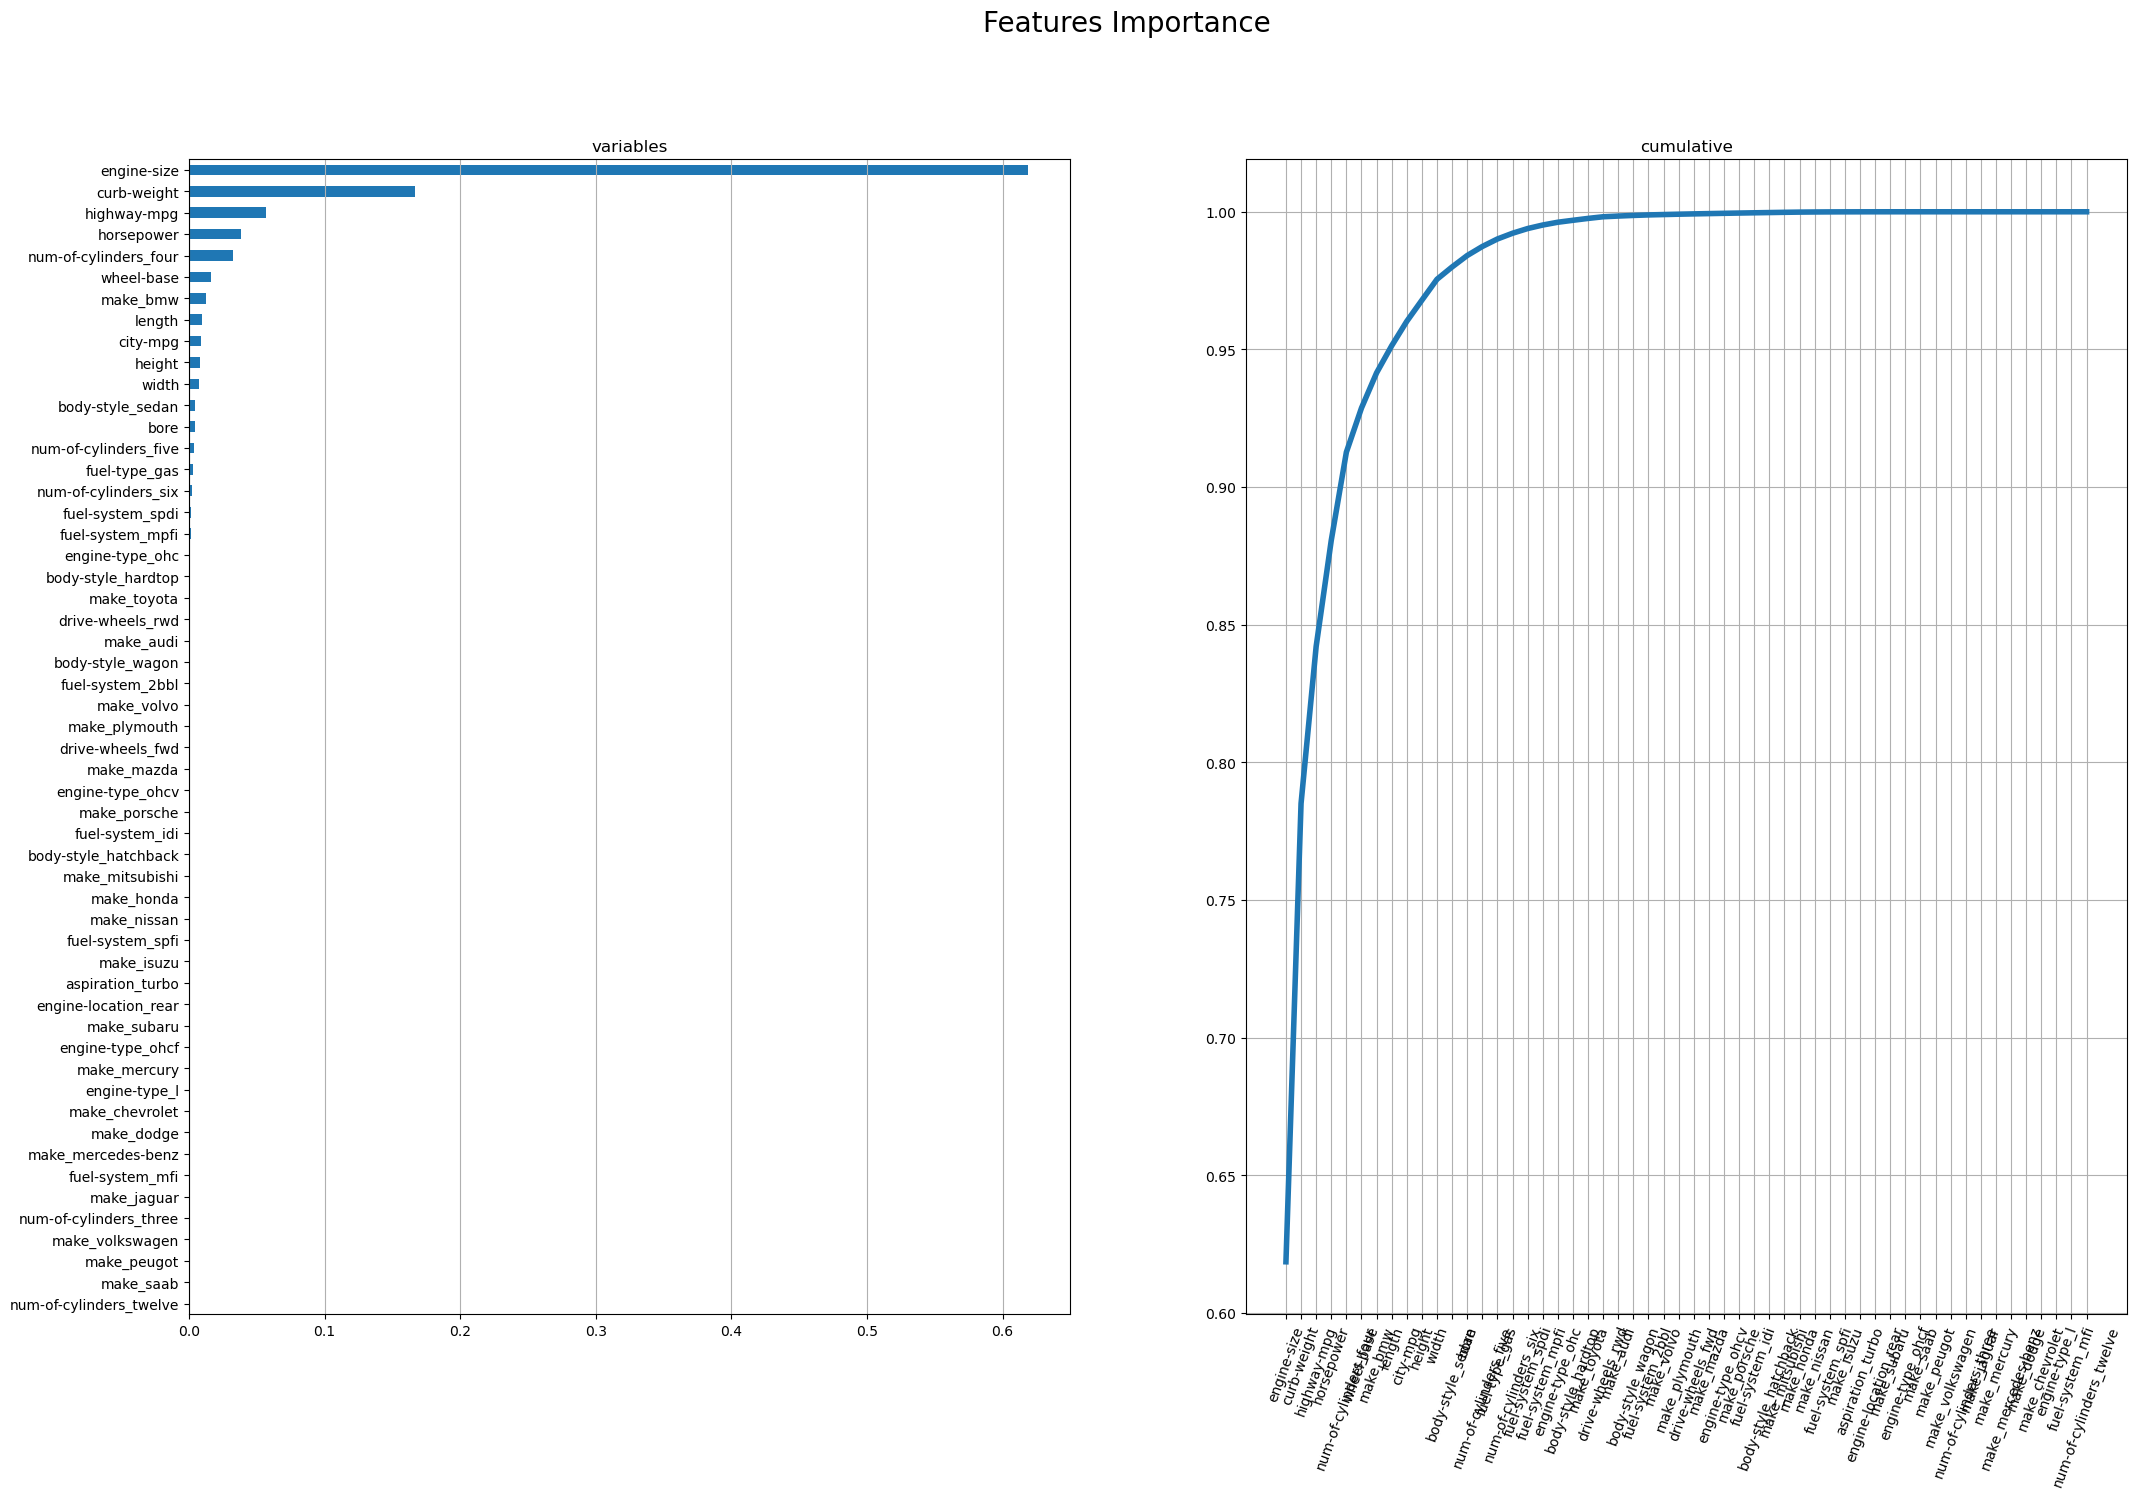

In [128]:
X = df_train.drop("price", axis=1).values
y = df_train["price"].values
feature_names = df_train.drop("price", axis=1).columns.tolist()
# call model
model = GradientBoostingRegressor()
# Importance
model.fit(X, y)
importances = model.feature_importances_
# Put in a pandas df
df_importances = pd.DataFrame({"IMPORTANCE": importances,
                                "VARIABLE": feature_names}).sort_values("IMPORTANCE",
                                                                        ascending=False)
df_importances['cumsum'] = df_importances['IMPORTANCE'].cumsum(axis=0)
df_importances = df_importances.set_index("VARIABLE")

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False,
                       sharey=False, figsize=(25, 15))
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
df_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
    kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
df_importances[["cumsum"]].plot(kind="line", linewidth=4,
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(df_importances)),
          xticklabels=df_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()


## Feature Scaling

In [129]:
sc = StandardScaler()
x = sc.fit_transform(df_train.drop(columns=["price"]))
y = sc.transform(df_test.drop(columns=["price"]))
x = pd.DataFrame(x, columns=df_train.drop(
    columns=["price"]).columns, index=df_train.drop(columns=["price"]).index)
y = pd.DataFrame(y, columns=df_test.drop(columns=["price"]).columns,
                 index=df_test.drop(columns=["price"]).index)

x["price"] = df_train["price"]
y["price"] = df_test["price"]

df_train = x
df_test = y

In [130]:
X_names = ['engine-size', 'curb-weight', "horsepower", "highway-mpg", "width", "length"]
X_train = df_train[X_names].values
y_train = df_train["price"].values
X_test = df_test[X_names].values
y_test = df_test["price"].values

# Model selection and K-Fold Cross Validation on the regression models

In [131]:
def model_training(model, X_train, Y_train, splits):
    scores = []
    cv = KFold(n_splits=splits, shuffle=True)
    fig = plt.figure()
    i = 1
    for train, test in cv.split(X_train, Y_train):
        prediction = model.fit(X_train[train],
                               Y_train[train]).predict(X_train[test])
        true = Y_train[test]
        score = r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3,
                    label='Fold %d (R2 = %0.2f)' % (i, score))
        i = i+1
    plt.plot([min(Y_train), max(Y_train)], [min(Y_train), max(Y_train)],
            linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"K-Fold Validation of {model.__str__()}")
    plt.legend()
    plt.show()
    return np.array(scores).mean()

In [132]:
def accuracy_score(model, X_train, Y_train, splits):
    accuracies = cross_val_score(
        estimator=model, X=X_train, y=Y_train, cv=splits)
    print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
    print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))


## Linear Regression Before PCA

### Linear Regression KFold and Prediction

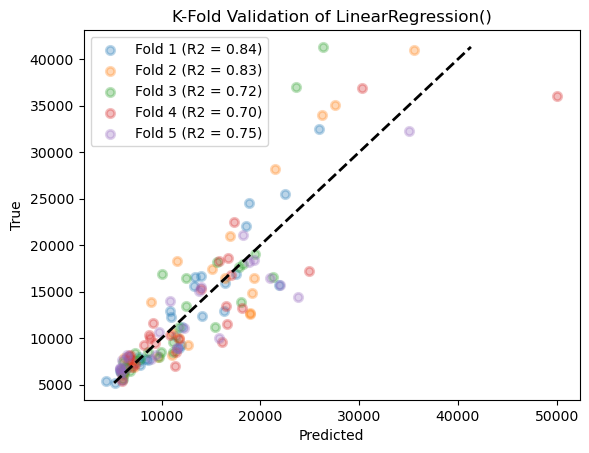

R-Squared :  0.7674244562975158
Mean Squared Error :  3591.9412978640707


In [133]:
linreg = LinearRegression()
print("R-Squared : ", model_training(linreg, X_train=X_train, Y_train=y_train, splits=5))
y_linreg_pred = linreg.predict(X_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_linreg_pred, y_true=y_test)**(1/2))

### Linear Regression Accuracy

In [134]:
accuracy_score(linreg, X_train=X_train, Y_train=y_train, splits=5)

Accuracy: 73.74 %
Standard Deviation: 7.38 %


## Gradient Boosting Regressor Before PCA

### Gradient Boosting Regressor KFold and Prediction

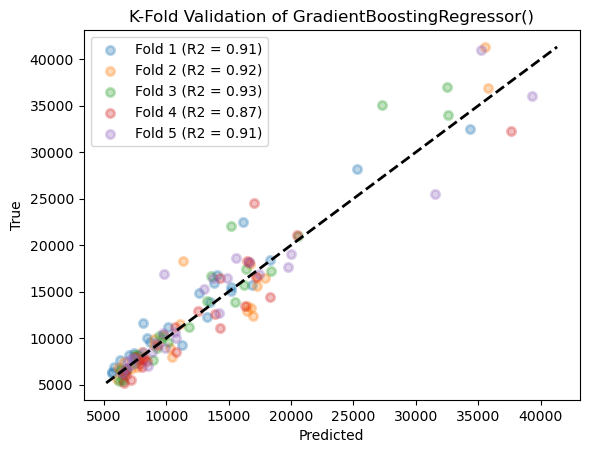

R-Squared :  0.9087458411210043
Mean Squared Error :  2783.224406402274


In [135]:
gradBoost = GradientBoostingRegressor()
print("R-Squared : ", model_training(gradBoost, X_train=X_train, Y_train=y_train, splits=5))
y_gradBoost = gradBoost.predict(X_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_gradBoost, y_true=y_test)**(1/2))


### Gradient Boosting Regressor Accuracy

In [136]:
accuracy_score(gradBoost, X_train=X_train, Y_train=y_train, splits=5)


Accuracy: 91.84 %
Standard Deviation: 2.34 %


## Support Vector Regressor Before PCA

### Support Vector  Regressor KFold and Prediction

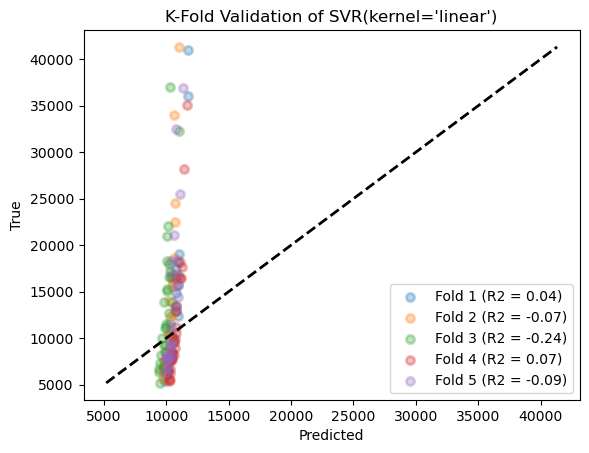

R-Squared :  -0.05573322333849375
Mean Squared Error :  8623.043961857888


In [137]:
svr = SVR(kernel="linear")
print("R-Squared : ", model_training(svr, X_train=X_train, Y_train=y_train, splits=5))
y_svr = svr.predict(X_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_svr, y_true=y_test)**(1/2))


### Support Vector  Regressor Accuracy

In [138]:
accuracy_score(svr, X_train=X_train, Y_train=y_train, splits=5)


Accuracy: -4.70 %
Standard Deviation: 11.24 %


## Decision Tree Regressor Before PCA

### Decision Tree Regressor KFold and Prediction

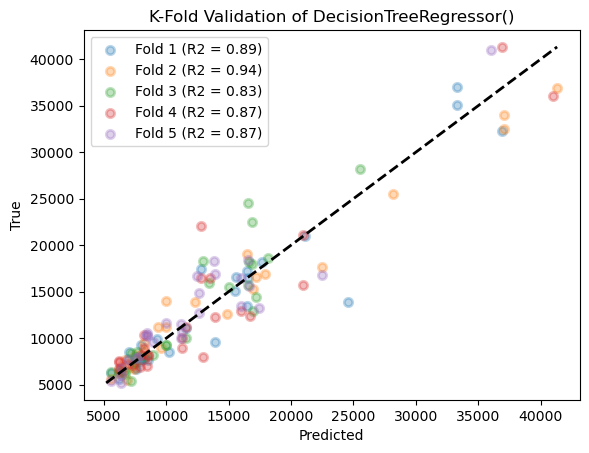

R-Squared :  0.8810769285302825
Mean Squared Error :  2921.1015683952787


In [139]:
dtr = DecisionTreeRegressor()

print("R-Squared : ", model_training(dtr, X_train=X_train, Y_train=y_train, splits=5))
y_dtr = dtr.predict(X_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_dtr, y_true=y_test)**(1/2))

### Decision Tree Regressor Accuracy

In [140]:
accuracy_score(dtr, X_train=X_train, Y_train=y_train, splits=5)


Accuracy: 84.58 %
Standard Deviation: 3.93 %


## Random Forest Regressor Before PCA

### Random Forest Regressor KFold and Prediction

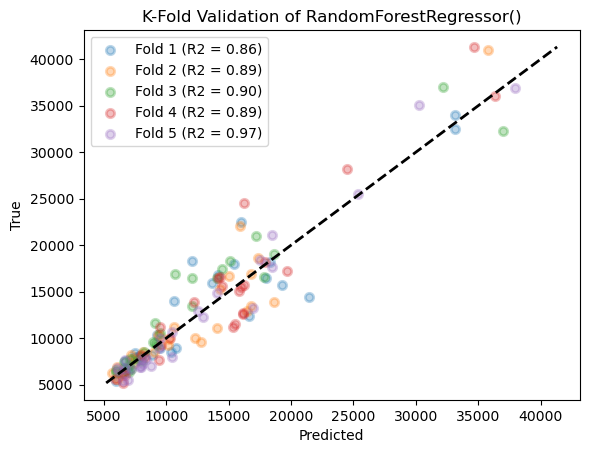

R-Squared :  0.9008356618928349
Mean Squared Error :  3591.9412978640707


In [141]:
rfr = RandomForestRegressor()
print("R-Squared : ", model_training(rfr, X_train=X_train, Y_train=y_train, splits=5))
y_rfr= linreg.predict(X_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_rfr, y_true=y_test)**(1/2))


### Random Forest Regressor Accuracy

In [142]:
accuracy_score(rfr, X_train=X_train, Y_train=y_train, splits=5)


Accuracy: 89.27 %
Standard Deviation: 4.75 %


# Perform feature extraction using Principal Component Analysis (PCA) and Model Prediction Accuracy

In [143]:
def PCA_with_component(component, X_train, X_test):
    pca = PCA(n_components=component)

    X_pca_train = pca.fit_transform(X_train)
    X_pca_test = pca.transform(X_test)

    # Get the number of features remaining
    n_components = pca.n_components_

    print(f"Number of features remaining after PCA: {n_components}")

    if n_components == 2:
        # Create a new DataFrame to hold the PCA data
        df_pca = pd.DataFrame(X_pca_train, columns=['PC1', 'PC2'])

        # Create scatter plot of the first two principal components
        sb.scatterplot(x='PC1', y='PC2', data=df_pca)

        # Set plot title and axis labels
        plt.title('PCA plot')
        plt.xlabel('PC1')
        plt.ylabel('PC2')

        # Show plot
        plt.show()
    return X_pca_train, X_pca_test

## Performing PCA

Number of features remaining after PCA: 2


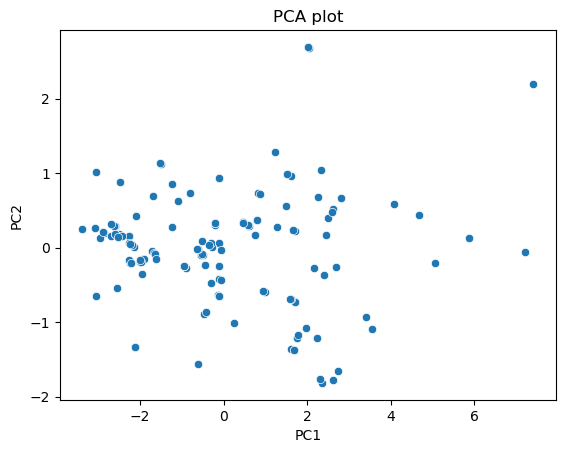

In [144]:
X_pca_train, X_pca_test = PCA_with_component(2, X_train=X_train, X_test=X_test)

## Linear Regression After PCA

### Linear Regression KFold and Prediction

Number of features remaining after PCA: 3


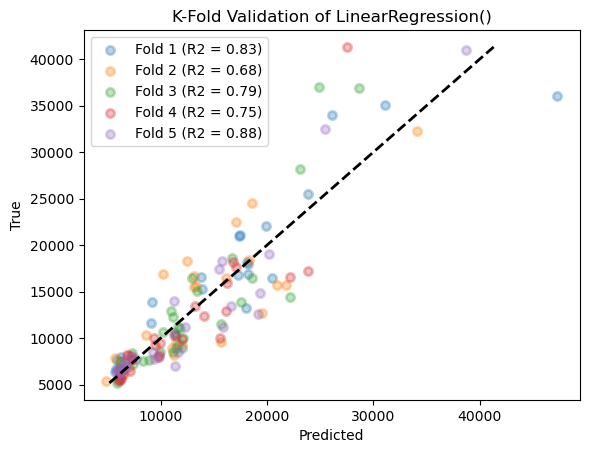

R-Squared :  0.7870887115879129
Mean Squared Error :  3430.2897715029267


In [145]:
linreg = LinearRegression()
X_pca_train, X_pca_test = PCA_with_component(3, X_train=X_train, X_test=X_test)
print("R-Squared : ", model_training(linreg, X_train=X_pca_train, Y_train=y_train, splits=5))
y_linreg_pred = linreg.predict(X_pca_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_linreg_pred, y_true=y_test)**(1/2))

### Linear Regression Accuracy

In [146]:
accuracy_score(linreg, X_train=X_pca_train, Y_train=y_train, splits=5)


Accuracy: 74.85 %
Standard Deviation: 7.49 %


## Gradient Boosting Regressor After PCA

### Gradient Boosting Regressor KFold and Prediction

Number of features remaining after PCA: 2


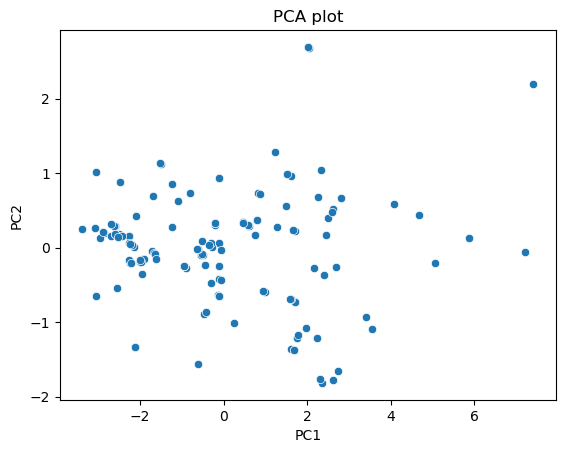

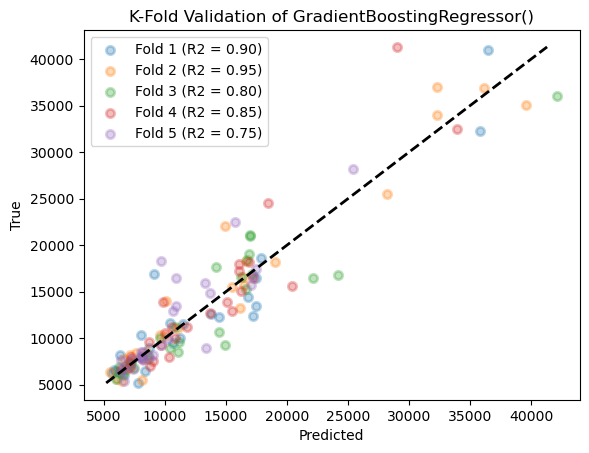

R-Squared :  0.8485282452265132
Mean Squared Error :  2445.674389224667


In [147]:
gradBoost = GradientBoostingRegressor()
X_pca_train, X_pca_test = PCA_with_component(2, X_train=X_train, X_test=X_test)
print("R-Squared : ", model_training(gradBoost, X_train=X_pca_train, Y_train=y_train, splits=5))
y_gradBoost = gradBoost.predict(X_pca_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_gradBoost, y_true=y_test)**(1/2))


### Gradient Boosting Regressor Accuracy

In [148]:
accuracy_score(gradBoost, X_train=X_pca_train, Y_train=y_train, splits=5)

Accuracy: 76.37 %
Standard Deviation: 14.03 %


## Support Vector Regressor After PCA

### Support Vector Regressor KFold and Prediction

Number of features remaining after PCA: 5


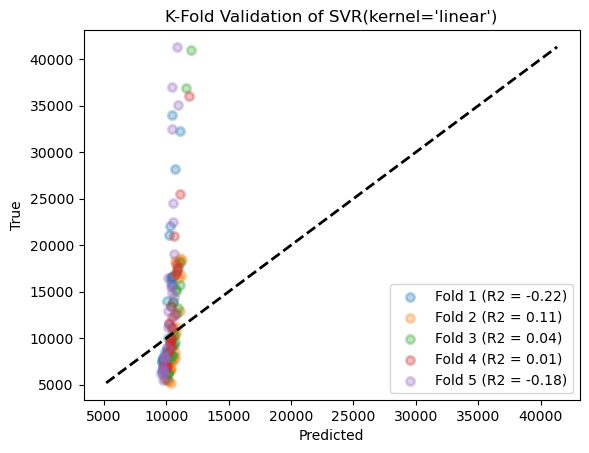

R-Squared :  -0.046600331055535
Mean Squared Error :  8745.386542680093


In [149]:
svr = SVR(kernel="linear")
X_pca_train, X_pca_test = PCA_with_component(5, X_train=X_train, X_test=X_test)
print("R-Squared : ", model_training(svr, X_train=X_pca_train, Y_train=y_train, splits=5))
y_svr = svr.predict(X_pca_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_svr, y_true=y_test)**(1/2))

### Support Vector Regressor Accuracy

In [150]:
accuracy_score(svr, X_train=X_pca_train, Y_train=y_train, splits=5)

Accuracy: -4.71 %
Standard Deviation: 11.24 %


## Decision Tree Regressor After PCA

### Decision Tree Regressor KFold and Prediction

Number of features remaining after PCA: 1


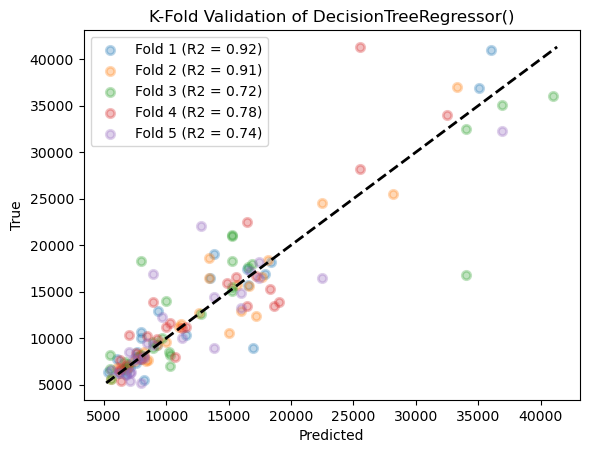

R-Squared :  0.8112107142400697
Mean Squared Error :  3031.3007752168887


In [151]:
dtr = DecisionTreeRegressor()
X_pca_train, X_pca_test = PCA_with_component(1, X_train=X_train, X_test=X_test)
print("R-Squared : ", model_training(dtr, X_train=X_pca_train, Y_train=y_train, splits=5))
y_dtr = dtr.predict(X_pca_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_dtr, y_true=y_test)**(1/2))

### Decision Tree Regressor Accuracy

In [152]:
accuracy_score(dtr, X_train=X_pca_train, Y_train=y_train, splits=5)

Accuracy: 70.93 %
Standard Deviation: 15.59 %


## Random Forest Regressor After PCA

### Random Forest Regressor KFold and Prediction

Number of features remaining after PCA: 3


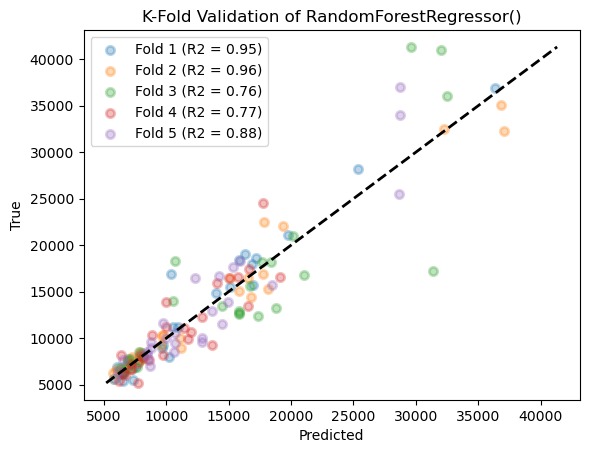

R-Squared :  0.8625474882903255
Mean Squared Error :  2450.738651162481


In [153]:
rfr = RandomForestRegressor()
X_pca_train, X_pca_test = PCA_with_component(3, X_train=X_train, X_test=X_test)
print("R-Squared : ", model_training(rfr, X_train=X_pca_train, Y_train=y_train, splits=5))
y_rfr = rfr.predict(X_pca_test)
print("Mean Squared Error : ",mean_squared_error(y_pred=y_rfr, y_true=y_test)**(1/2))

### Random Forest Regressor Accuracy

In [154]:
accuracy_score(rfr, X_train=X_pca_train, Y_train=y_train, splits=5)

Accuracy: 76.26 %
Standard Deviation: 12.36 %
